###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     1268256


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [4]:
# Import relevant packages
import numpy as np
import pandas as pd

In [5]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(pathname):
    """
    We want to extract the dataframe containing all attribute value pairs, as well as a Series of corresponding labels
    """
    df = pd.read_csv(pathname)
    df = df.drop('filename',axis=1) # Don't need filename
    labels = df['label']
    df = df.drop('label', axis=1) # Don't want label in our attribute-value table
    return (df, labels)

In [6]:
def train(df, labels):
    """
    This function should calculate prior probabilities and conditional likelihoods from the training data
    Such that we have the necessary data for a Naive Bayes model
    """
    return (prior_prob(labels), conditional_likelihoods(df, labels))
    
def prior_prob(labels):
    """
    Auxiliary to calculate all label prior probabilities
    """
    priors = {}

    unique_labels, counts = np.unique(labels, return_counts=True)
    n = sum(counts)

    for i in range(len(unique_labels)):
        # Get the proportion this label occurs in the entire dataset
        priors[unique_labels[i]] = (counts[i] / n).round(2)

    return priors

def conditional_likelihoods(df, labels):
    """
    Auxiliary to calculate the likelihood of each feature given a label
    """
    
    # Get all the features excluding filename and label
    features = df.columns
    unique_labels = np.unique(labels)

    # Get the approximated Normal distribution for the feature given the class
    distributions = {}
    for feature in features:
        feature_values = df[feature]
        distributions[feature] = {}
        # Intialise a dictionary which will be used to store the feature values associated with each label
        feature_classes = {}
        for label in unique_labels:
            feature_classes[label] = []

        # Then fill in this dictionary
        for (value, label) in zip(feature_values, labels):
            feature_classes[label].append(value)

        # Then we can calculate the Normal distribution parameters for Pr(Feature Value|Class Label)
        for (key, value) in feature_classes.items():
            # Store a tuple of the mu and sigma for a feature and class
            distributions[feature][key] = (np.mean(value), np.std(value))
            
    return distributions

(train_df, train_labels) = preprocess("pop_vs_classical_train.csv")
(priors, distributions) = train(train_df, train_labels)

In [36]:
def predict(df, priors, distributions):
    """
    Predict the classes for new items in a test dataset
    """
    predictions = []
    for index, row in df.iterrows():
        # For each row, predict the log likelihood of each possible label given the data
        log_likelihoods = []
        for label in priors.keys():
            # Get the Bayes formula relative likelihood for this combo of label and row
            log_likelihood = np.log(priors[label])
            for (attribute, value) in row.items():
                if (attribute == "label" or attribute == "filename"):
                    continue
                log_likelihood = log_likelihood + log_gaussian(value, distributions[attribute][label])

            # Append a tuple containing the label, and the log probability calculation
            log_likelihoods.append((label, log_likelihood))

        # Extract the maximum likelihood, which dictates our prediction
        argmax = max(log_likelihoods, key=lambda x:x[1])[0]
        predictions.append(argmax)

    # Modify the original dataframe to include the predictions
    merged_df = df.copy()
    merged_df['prediction'] = predictions
    # We can now move the labels back onto the original dataframe for evaluation
    return merged_df

def log_gaussian(x, distribution):
    """
    Return the natural log of the gaussian distribution with mean mu and sd sigma, for a realisation x
    Since we are only calculating relative probabilities, we can comfortably exclude the inclusion of sqrt(2pi)
    """
    mu = distribution[0]
    sigma = distribution[1]
    return np.log(1/sigma) - (((x-mu)**2) / (2*(sigma**2)))

(train_df, train_labels) = preprocess("pop_vs_classical_train.csv")
(test_df, test_labels) = preprocess("pop_vs_classical_test.csv")
(priors, distributions) = train(train_df, train_labels)
test_df = predict(test_df, priors, distributions)

In [37]:
# This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(df, positive_label):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    total = 0
    for index, row in df.iterrows():
        total += 1
        # Classify in a one-vs-all fashion
        if row['label'] == row['prediction']:
            tp += 1
        elif row['label'] == positive_label:
            # They were not equal and the label was positive - this must be a false negative
            fn += 1
        elif row['prediction'] == positive_label:
            # This must be a false positive - the prediction is positive but not equal to the label
            fp += 1
        else:
            # True negative (remember this is one-vs-all)
            tn += 1

    # Return accuracy, precision and recall
    accuracy = (tp+tn)/total
    precision = tp/(tp+fp) if (tp+fp != 0) else 0 # Proportion of positively labelled classes that were correct
    recall = tp/(tp+fn) if (tp+fn != 0) else 0 # Proportion of positive classes labelled correctly
    return (accuracy, precision, recall)

df_test = pd.concat([test_df, test_labels], axis = 1)

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [38]:
# Get (accuracy, precision, recall) - treating classical as the positive label
evaluate(df_test, "classical")

(0.9767441860465116, 0.9767441860465116, 1.0)

Using the test dataset, the accuracy of the model is 0.977, while the precision is 0.952 and recall is 1.0

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

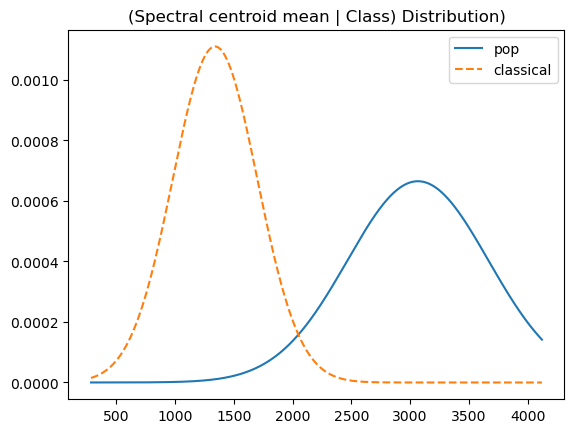

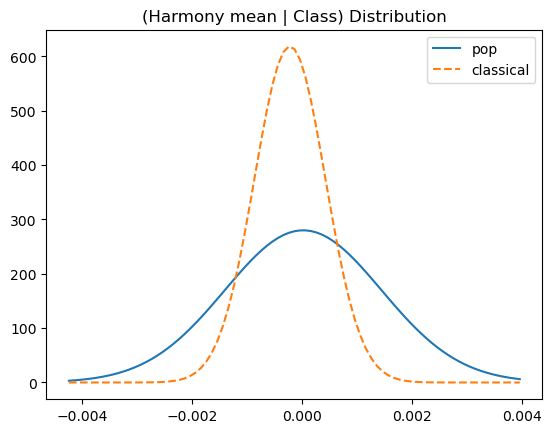

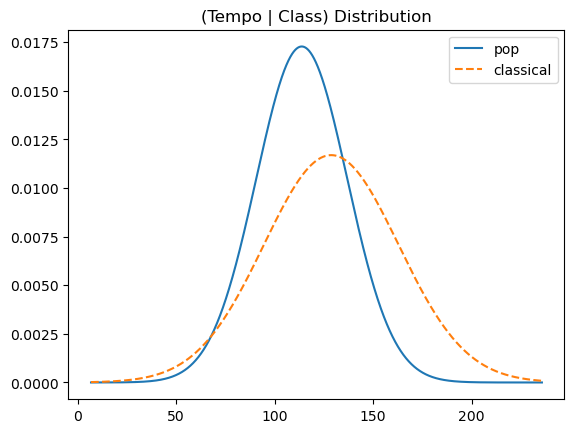

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# P(spectral_centroid_mean | Class)
spectral_pop = distributions['spectral_centroid_mean']['pop']
spectral_classical = distributions['spectral_centroid_mean']['classical']

# P(harmony mean | Class)
harmony_pop = distributions['harmony_mean']['pop']
harmony_classical = distributions['harmony_mean']['classical']

# P(tempo | Class)
tempo_pop = distributions['tempo']['pop']
tempo_classical = distributions['tempo']['classical']

def plotAttribute(given_pop, given_classical, title, step_size=0.001):
    """
    Plot the conditional distributions for an attribute
    """
    centre = (given_pop[0]+given_classical[0])/2
    range = (given_pop[1]+given_classical[1])*2
    x_axis = np.arange(centre - range, centre + range, step_size)
    plt.plot(x_axis, norm.pdf(x_axis,given_pop[0],given_pop[1]), label="pop")
    plt.plot(x_axis, norm.pdf(x_axis,given_classical[0],given_classical[1]), label="classical", linestyle="dashed")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot spectral centroid mean.
plotAttribute(spectral_pop, spectral_classical, "(Spectral centroid mean | Class) Distribution)")

# Plot harmony mean.
plotAttribute(harmony_pop, harmony_classical, "(Harmony mean | Class) Distribution", 0.0001)

# Plot tempo.
plotAttribute(tempo_pop, tempo_classical, "(Tempo | Class) Distribution")


Clearly if you were to classify pop vs classical using just one of these features, these plots strongly support the choice of Spectral centroid mean. The distributions for this attribute conditional on pop vs classical have the least overlap - which directly corresponds to the lowest error rate when using this attribute to predict the class label. Meanwhile, Harmony mean and Tempo have very similar distributions, in particular a close mean which leads to a lot of overlap and makes it much more likely that an instance classes as pop based on these attributes is actually classical and vise versa. Spectral centroid mean is clearly a far more distinguishing feature and thus better to make a prediction with.

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

RESULTS: {2: (0.9036, 0.9163648694218984, 0.9163752506182407), 4: (0.9045999999999998, 0.9181892208248875, 0.9180773451562044), 6: (0.9040004328692013, 0.9178058253245459, 0.9176192589062641), 8: (0.9044, 0.9182215644914706, 0.9181960779833174), 10: (0.9060000000000002, 0.920843754153986, 0.9208157581467118), 12: (0.9051993689041882, 0.9192203801143354, 0.9190678854869431), 14: (0.9055918846411803, 0.919551723272338, 0.919546289694681), 16: (0.903997055811572, 0.916956952697121, 0.9167354456920859), 18: (0.9056240981240982, 0.9195336674869365, 0.9191613219024811), 20: (0.9044000000000001, 0.9162947909360584, 0.9161263426387467), 22: (0.9071980676328505, 0.9211079992846674, 0.920929588311801), 24: (0.9057975222609369, 0.9195329254693121, 0.9192918406834826), 26: (0.9054084916433094, 0.9186805359110308, 0.9186901096342088), 28: (0.9057709750566892, 0.9180474767906317, 0.9179365345519629), 30: (0.9044147355912062, 0.9184003278092131, 0.9177793237265071), 32: (0.9055569556451613, 0.9201674

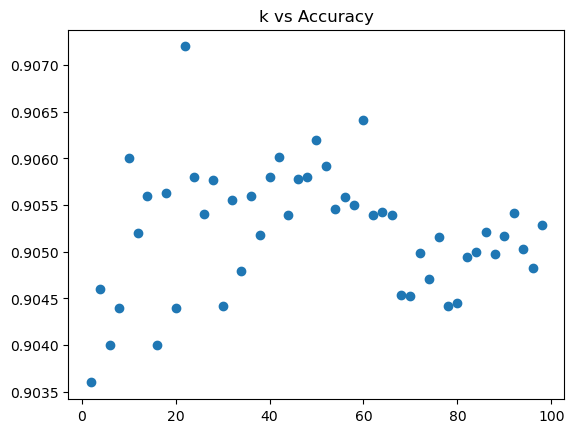

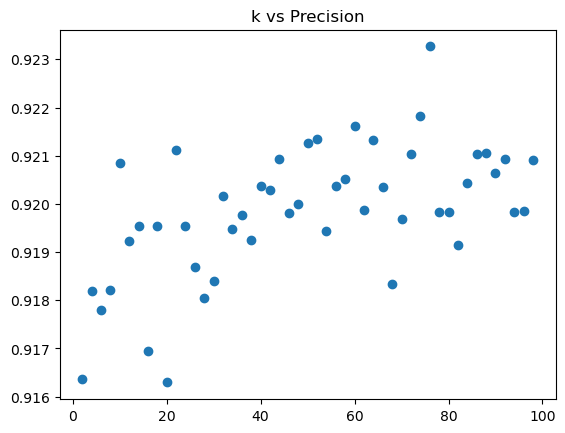

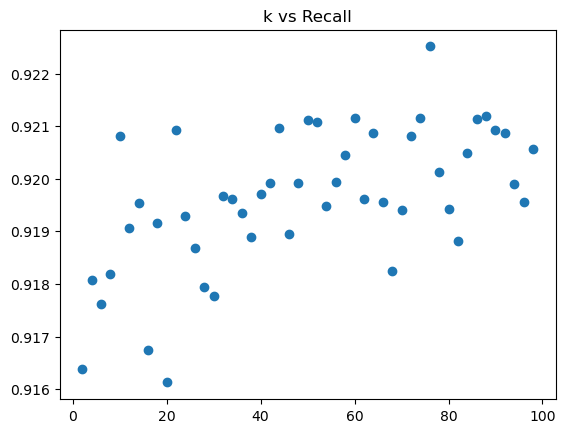

In [50]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

(train_df, train_labels) = preprocess("gztan_train.csv")
(test_df, test_labels) = preprocess("gztan_test.csv")

# We want to merge the datasets so we can do our own train/test split
labelled_train = pd.concat([train_df, train_labels], axis = 1)
labelled_test = pd.concat([test_df, test_labels], axis = 1)
X = pd.concat([train_df, test_df])
y = pd.concat([train_labels, test_labels])
unique_labels = np.unique(y)

results = {}

# Evaluate the model on various values of K for the K fold cross validation
for k in range(2, 100, 2):
    # Should shuffle as looking at the dataset, classes are clumped together
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    accs = []
    precisions = []
    recalls = []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Construct the training and testing set for this split
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        (priors, distributions) = train(X_train, y_train)
        X_test = predict(X_test, priors, distributions)
        test_df = pd.concat([X_test, y_test], axis = 1)
        
        tot_acc = 0
        tot_precision = 0
        tot_recall = 0
        # We now want to find the macro-average evaluation for this k-fold cross validation
        for label in unique_labels:
            (acc, precision, recall) = evaluate(test_df, label)
            tot_acc += acc
            tot_precision += precision
            tot_recall += recall

        # Append this as the model performance result for this value of k
        accs.append(tot_acc / unique_labels.size)
        precisions.append(tot_precision / unique_labels.size)
        recalls.append(tot_recall / unique_labels.size)
    
    results[k] = (np.mean(accs), np.mean(precisions), np.mean(recalls))


def plotk(metric, metricName, results):
    X = []
    y = []
    for (key, value) in results.items():
        X.append(key)
        y.append(value[metric])
    plt.scatter(X, y)
    plt.title(f"k vs {metricName}")
    plt.show()

print("RESULTS:", results)
plotk(0, "Accuracy", results)
plotk(1, "Precision", results)
plotk(2, "Recall", results)



In this simulation, values from k=2 to k=100 (with a step of 2) were used to perform k-fold cross validation, in particular to observe the effect that varying k has on the performance of the Naive Bayes model. It should be noted that higher values of k result in larger training set sizes; thus increasing k enables us to observe the effect that a larger training set size has on model performance while still cross-fold validating. Note these metrics were derived in a macro-averaging, one-vs-all fashion.

Firstly, when comparing all evaluation metrics, it seems quite apparent that the performance of the model in all metrics has a positive linear trend prior to around k = 40. This is almost certainly due to training set sizes increasing and optimally tuning the parameters of the model. 
However, after this k = 40 to 50 range, the precision and recall metrics appear to somewhat plateau, while accuracy in fact has a clear decreasing trend. This suggests that beyond this range, where the train test split is even higher than 98/2, the model is clearly either overfitting, or does not have a large enough test set for a consistent evaluation.

It should be acknowledged that all these variations are still quite small, and train/test split (when > 50/50, as here) seemingly has little effect on overall model performance. If the training were lower than 50%, performance is much more likely to deteriorate, and issues with zero probabilities emerge - requiring smoothing.
